#Lab: Residual Networks — MLP (MNIST1D) to 1D Conv and 2D Conv **Total: 10 marks**

Lab6 submission by Arnav Aditya, Roll no. 2210110189

# **Overview:**
 - This notebook provides a working PyTorch boilerplate implementing a residual MLP trained on a 1D version of MNIST (MNIST1D).
 - You will extend the code to (a) a residual 1D convolutional network and (b) a residual 2D convolutional network.
 - For the 1D conv task, use the provided *MNIST1D* representation (treat each image as a 1×784 1D signal).
 - For the 2D conv task, use **CIFAR-10** (32×32 RGB) as the dataset.

# Hints:
 - Keep residual blocks simple (Conv-BN-ReLU -> Conv-BN + skip -> ReLU).
 - For 1D conv: use `nn.Conv1d` with input channel 1 and kernel sizes like 3 or 5.
 - For 2D conv: start from a small ResNet-like block (use stride 1 / 2 when downsampling).
 - Use `torchvision.datasets.MNIST` for MNIST1D (reshape) and `torchvision.datasets.CIFAR10` for CIFAR-10.
 - Use SGD/Adam, and train for a small number of epochs first (e.g., 10) to validate your pipeline.

In [1]:
# Standard imports and utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt


# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [2]:
# %%
def set_seed(seed=42):
  import random, numpy as np
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed()

In [ ]:
# Simple training loop
def train_one_epoch(model, loader, criterion, optimizer, device):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0
  for x, y in loader:
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    out = model(x)
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * x.size(0)
    _, preds = out.max(1)
    correct += (preds == y).sum().item()
    total += x.size(0)
  return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)
      out = model(x)
      loss = criterion(out, y)
      running_loss += loss.item() * x.size(0)
      _, preds = out.max(1)
      correct += (preds == y).sum().item()
      total += x.size(0)
  return running_loss / total, correct / total

In [4]:
# Plotting utility
def plot_curves(hist, title=None):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(hist['train_loss'], label='train_loss')
    plt.plot(hist['val_loss'], label='val_loss')
    plt.legend()
    plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(hist['train_acc'], label='train_acc')
    plt.plot(hist['val_acc'], label='val_acc')
    plt.legend()
    plt.grid(True)
    if title: plt.suptitle(title)
    plt.show()

In [5]:
# Data: MNIST1D loaders
batch_size = 128
transform_mnist = transforms.Compose([
transforms.ToTensor(),
# We'll flatten in the dataset transform step below
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:09<00:00, 1.03MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 82.9kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:15<00:00, 106kB/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.57MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
# Wrap to reshape images into (1, 784)
class MNIST1D(Dataset):
  def __init__(self, base_dataset):
    self.base = base_dataset
  def __len__(self):
    return len(self.base)
  def __getitem__(self, idx):
    x, y = self.base[idx]
    # x shape: [1, 28, 28] -> reshape to [1, 784]
    x = x.view(1, -1)
    return x, y

train_loader_1d = DataLoader(MNIST1D(trainset), batch_size=batch_size, shuffle=True, num_workers=2)
test_loader_1d = DataLoader(MNIST1D(testset), batch_size=batch_size, shuffle=False, num_workers=2)

In [7]:
# Residual MLP boilerplate
class ResidualMLP(nn.Module):
  def __init__(self, in_features=784, hidden=512, n_classes=10):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden)
    self.bn1 = nn.BatchNorm1d(hidden)
    self.fc2 = nn.Linear(hidden, hidden)
    self.bn2 = nn.BatchNorm1d(hidden)
    self.fc_out = nn.Linear(hidden, n_classes)


  def forward(self, x):
    # x: [B, 1, 784]
    x = x.squeeze(1) # -> [B, 784]
    h = F.relu(self.bn1(self.fc1(x)))
    h2 = self.bn2(self.fc2(h))
    h = F.relu(h + h2) # residual connection across two linear layers
    out = self.fc_out(h)
    return out

#1) We treat each MNIST image (28×28) as a flattened 1×784 1D signal. The provided MLP has a residual connection across two linear layers.

 **Task:** Run the cells below to get a baseline test accuracy. Finetune hyperparameters. (2 marks)

Epoch 1/40 — train_loss: 2.3144, train_acc: 0.0938, val_acc: 0.2579, time: 1.4s
Epoch 2/40 — train_loss: 1.4197, train_acc: 0.5729, val_acc: 0.5112, time: 1.4s
Epoch 3/40 — train_loss: 0.9605, train_acc: 0.7083, val_acc: 0.6601, time: 1.4s
Epoch 4/40 — train_loss: 1.0769, train_acc: 0.6979, val_acc: 0.7289, time: 1.4s
Epoch 5/40 — train_loss: 0.6346, train_acc: 0.8333, val_acc: 0.7575, time: 1.4s
Epoch 6/40 — train_loss: 0.5664, train_acc: 0.8229, val_acc: 0.7648, time: 1.3s
Epoch 7/40 — train_loss: 0.5291, train_acc: 0.8438, val_acc: 0.7713, time: 1.4s
Epoch 8/40 — train_loss: 0.6143, train_acc: 0.8438, val_acc: 0.7754, time: 1.4s
Epoch 9/40 — train_loss: 0.4917, train_acc: 0.8333, val_acc: 0.7868, time: 1.4s
Epoch 10/40 — train_loss: 0.5187, train_acc: 0.8542, val_acc: 0.8003, time: 1.4s
Epoch 11/40 — train_loss: 0.5588, train_acc: 0.8021, val_acc: 0.8250, time: 1.3s
Epoch 12/40 — train_loss: 0.4855, train_acc: 0.8229, val_acc: 0.8443, time: 1.4s
Epoch 13/40 — train_loss: 0.4679, tra

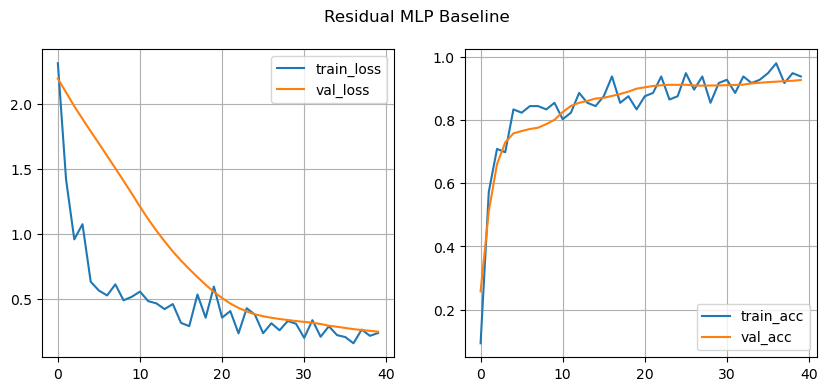

In [12]:
# Train the MLP baseline for a few epochs (students can run longer for better accuracy)
model_mlp = ResidualMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=1e-3)

hist = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

n_epochs = 40
for epoch in range(n_epochs):
  t0 = time.time()
  train_loss, train_acc = train_one_epoch(model_mlp, train_loader_1d, criterion, optimizer, device)
  val_loss, val_acc = evaluate(model_mlp, test_loader_1d, criterion, device)
  hist['train_loss'].append(train_loss)
  hist['val_loss'].append(val_loss)
  hist['train_acc'].append(train_acc)
  hist['val_acc'].append(val_acc)
  print(f"Epoch {epoch+1}/{n_epochs} — train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}, time: {time.time()-t0:.1f}s")


print('\nBaseline test evaluation:')
val_loss, val_acc = evaluate(model_mlp, test_loader_1d, criterion, device)
print(f'Test loss: {val_loss:.4f}, Test accuracy: {val_acc:.4f}')
plot_curves(hist, title='Residual MLP Baseline')

# 2)**Goal (3 marks):** 
Replace the MLP with a residual 1D conv network and train on MNIST1D (same dataset as above). Use `nn.Conv1d` layers and residual connections similar to a small ResNet block.

 **Dataset:** Use MNIST (reshaped to 1×784) — i.e., `MNIST1D` loader above.

 **Requirements:**
 - Implement a Residual1D class below. It should accept input with shape `[B, 1, 784]`.
 - Use at least two residual blocks. If necessary, change number of channels using 1×1 conv for the skip connection.
 - Train for at least 10 epochs and report final test accuracy and loss curves.


Training 1D Residual CNN...


Epoch 1/15 — train_loss: 0.6655, train_acc: 0.7901, val_acc: 0.8980, time: 5.1s
Epoch 2/15 — train_loss: 0.2695, train_acc: 0.9197, val_acc: 0.9375, time: 5.1s
Epoch 3/15 — train_loss: 0.2066, train_acc: 0.9388, val_acc: 0.9565, time: 5.1s
Epoch 4/15 — train_loss: 0.1756, train_acc: 0.9477, val_acc: 0.9582, time: 5.1s
Epoch 5/15 — train_loss: 0.1488, train_acc: 0.9547, val_acc: 0.9653, time: 5.1s
Epoch 6/15 — train_loss: 0.1389, train_acc: 0.9578, val_acc: 0.9640, time: 5.3s
Epoch 7/15 — train_loss: 0.1287, train_acc: 0.9607, val_acc: 0.9636, time: 5.2s
Epoch 8/15 — train_loss: 0.1187, train_acc: 0.9643, val_acc: 0.9716, time: 5.3s
Epoch 9/15 — train_loss: 0.1079, train_acc: 0.9673, val_acc: 0.9706, time: 5.1s
Epoch 10/15 — train_loss: 0.1016, train_acc: 0.9687, val_acc: 0.9712, time: 5.1s
Epoch 11/15 — train_loss: 0.0963, train_acc: 0.9701, val_acc: 0.9679, time: 5.2s
Epoch 12/15 — train_loss: 0.0919, train_acc: 0.9721, val_acc: 0.9745, time: 5.2s
Epoch 13/15 — train_loss: 0.0863, tra

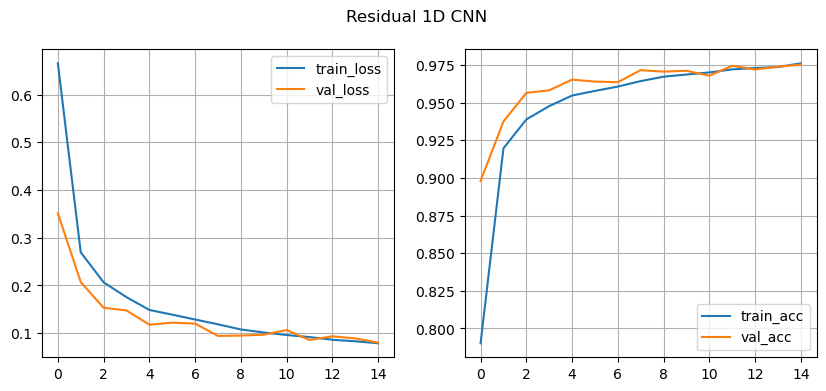

In [21]:
# Residual 1D Convolutional Block
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # Skip connection with 1x1 conv if channels don't match
        self.skip_connection = None
        if in_channels != out_channels or stride != 1:
            self.skip_connection = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )
    
    def forward(self, x):
        identity = x
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        if self.skip_connection is not None:
            identity = self.skip_connection(x)
        
        out += identity
        return F.relu(out)

# Residual 1D CNN Model
class Residual1D(nn.Module):
    def __init__(self, in_channels=1, n_classes=10):
        super().__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual blocks
        self.res_block1 = ResidualBlock1D(64, 64)
        self.res_block2 = ResidualBlock1D(64, 128, stride=2)  # downsample
        self.res_block3 = ResidualBlock1D(128, 256, stride=2)  # downsample
        
        # Global average pooling, dropout and classifier
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, n_classes)
        
    def forward(self, x):
        # x: [B, 1, 784]
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        x = self.global_avg_pool(x)  # [B, 256, 1]
        x = x.view(x.size(0), -1)    # [B, 256]
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

# Train the 1D Residual CNN
model_1d = Residual1D().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1d.parameters(), lr=1e-3, weight_decay=1e-4)

hist_1d = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

n_epochs = 15  # train for at least 10 epochs as required
print("Training 1D Residual CNN...")
for epoch in range(n_epochs):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model_1d, train_loader_1d, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model_1d, test_loader_1d, criterion, device)
    hist_1d['train_loss'].append(train_loss)
    hist_1d['val_loss'].append(val_loss)
    hist_1d['train_acc'].append(train_acc)
    hist_1d['val_acc'].append(val_acc)
    print(f"Epoch {epoch+1}/{n_epochs} — train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}, time: {time.time()-t0:.1f}s")

print('\n1D Residual CNN test evaluation:')
val_loss, val_acc = evaluate(model_1d, test_loader_1d, criterion, device)
print(f'Test loss: {val_loss:.4f}, Test accuracy: {val_acc:.4f}')
plot_curves(hist_1d, title='Residual 1D CNN')

# 3)**Goal (5 marks):** 
Build and train a small 2D residual network on **CIFAR-10**. Use `torchvision.datasets.CIFAR10` and standard 2D residual blocks (`nn.Conv2d`).

 **Dataset:** CIFAR-10 (32×32 RGB). Students may normalize with mean/std: ((0.4914, 0.4822, 0.4465),(0.247,0.243,0.261)).

 **Requirements:**
 - Implement `ResidualBlock2D` and `Residual2D` model. Use at least 3 residual blocks and downsampling where appropriate.
 - Train for at least 20 epochs (or fewer if compute-limited) and report train/val curves and final test accuracy.
 - Compare results to the 1D conv model: what changed and why? (short explanation in your report)

100%|██████████| 170M/170M [04:03<00:00, 699kB/s]    


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CIFAR-10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training samples: 50000, Test samples: 10000
Training 2D Residual CNN on CIFAR-10...
Model parameters: 4,906,122
Epoch 1/25 — train_loss: 1.4326, train_acc: 0.4752, val_acc: 0.5143, lr: 0.001000, time: 20.5s
Epoch 2/25 — train_loss: 1.0100, train_acc: 0.6403, val_acc: 0.5961, lr: 0.001000, time: 20.5s
Epoch 3/25 — train_loss: 0.8477, train_acc: 0.7023, val_acc: 0.7186, lr: 0.001000, time: 20.6s
Epoch 4/25 — train_loss: 0.7216, train_acc: 0.7516, val_acc: 0.7598, lr: 0.001000, time: 20.6s
Epoch 5/25 — train_loss: 0.6460, train_acc: 0.7793, val_acc: 0.7431, lr: 0.001000, time: 20.5s
Epoch 6/25 — train_loss: 0.5933, train_acc: 0.7970, val_acc: 0.7788, lr: 0.001000, time: 20.7s
Epoch 7/25 — train_loss: 0.5466, train_acc: 0.8147, val_acc: 0.8003, lr: 0.001000, time: 20.8s
Epoch 8/25 — train_loss:

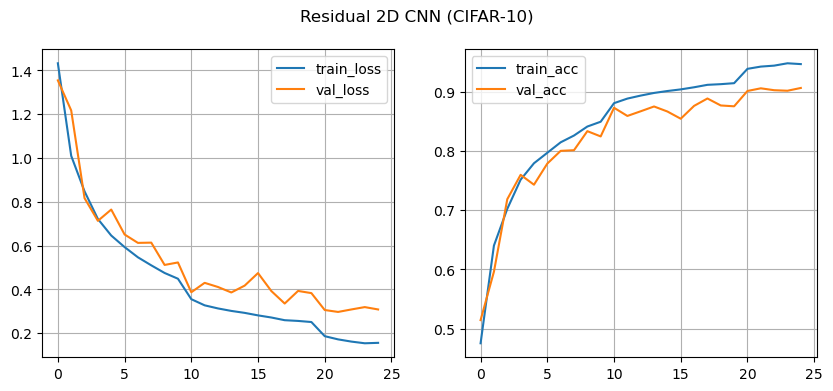


COMPARISON: 1D vs 2D Residual Networks
1D ResNet (MNIST1D) - Final test accuracy: 0.9753
2D ResNet (CIFAR-10) - Final test accuracy: 0.9066

Key Differences:
1. Dataset complexity: MNIST (grayscale digits) vs CIFAR-10 (color objects)
2. Input dimensions: 1D signal (784,) vs 2D images (32×32×3)
3. Spatial relationships: 1D temporal patterns vs 2D spatial patterns
4. Task difficulty: MNIST (~98-99% achievable) vs CIFAR-10 (~70-90% typical)
5. Model parameters: Different due to 1D vs 2D convolutions
6. Model size: 1D ResNet: 441,226 vs 2D ResNet: 4,906,122 parameters


In [ ]:
# CIFAR-10 data loaders with normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Data augmentation
    transforms.RandomHorizontalFlip(),     # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

trainset_cifar = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset_cifar = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader_2d = DataLoader(trainset_cifar, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader_2d = DataLoader(testset_cifar, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"CIFAR-10 classes: {trainset_cifar.classes}")
print(f"Training samples: {len(trainset_cifar)}, Test samples: {len(testset_cifar)}")

# Residual 2D Convolutional Block
class ResidualBlock2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection with 1x1 conv if channels don't match or stride != 1
        self.skip_connection = None
        if in_channels != out_channels or stride != 1:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = x
        
        # First conv + BN + ReLU
        out = F.relu(self.bn1(self.conv1(x)))
        # Second conv + BN (no ReLU yet)
        out = self.bn2(self.conv2(out))
        
        # Skip connection
        if self.skip_connection is not None:
            identity = self.skip_connection(x)
        
        # Add residual and apply ReLU
        out += identity
        return F.relu(out)

# Residual 2D CNN Model for CIFAR-10
class Residual2D(nn.Module):
    def __init__(self, in_channels=3, n_classes=10):
        super().__init__()
        
        # Initial convolution (32x32 -> 32x32)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Residual blocks with progressive downsampling
        self.res_block1 = ResidualBlock2D(64, 64, stride=1)    # 32x32 -> 32x32
        self.res_block2 = ResidualBlock2D(64, 128, stride=2)   # 32x32 -> 16x16
        self.res_block3 = ResidualBlock2D(128, 256, stride=2)  # 16x16 -> 8x8
        self.res_block4 = ResidualBlock2D(256, 512, stride=2)  # 8x8 -> 4x4
        
        # Global average pooling and classifier
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, n_classes)
        
    def forward(self, x):
        # x: [B, 3, 32, 32]
        x = F.relu(self.bn1(self.conv1(x)))
        
        x = self.res_block1(x)  # [B, 64, 32, 32]
        x = self.res_block2(x)  # [B, 128, 16, 16]
        x = self.res_block3(x)  # [B, 256, 8, 8]
        x = self.res_block4(x)  # [B, 512, 4, 4]
        
        x = self.global_avg_pool(x)  # [B, 512, 1, 1]
        x = x.view(x.size(0), -1)    # [B, 512]
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

# Train the 2D Residual CNN
model_2d = Residual2D().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2d.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Learning rate scheduling

hist_2d = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

n_epochs = 25  # train for at least 20 epochs as required
print("Training 2D Residual CNN on CIFAR-10...")
print(f"Model parameters: {sum(p.numel() for p in model_2d.parameters()):,}")

for epoch in range(n_epochs):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model_2d, train_loader_2d, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model_2d, test_loader_2d, criterion, device)
    
    # Step the scheduler
    scheduler.step()
    
    hist_2d['train_loss'].append(train_loss)
    hist_2d['val_loss'].append(val_loss)
    hist_2d['train_acc'].append(train_acc)
    hist_2d['val_acc'].append(val_acc)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{n_epochs} — train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, "
          f"val_acc: {val_acc:.4f}, lr: {current_lr:.6f}, time: {time.time()-t0:.1f}s")

print('\n2D Residual CNN test evaluation:')
val_loss, val_acc = evaluate(model_2d, test_loader_2d, criterion, device)
print(f'Final Test loss: {val_loss:.4f}, Final Test accuracy: {val_acc:.4f}')
plot_curves(hist_2d, title='Residual 2D CNN (CIFAR-10)')

# Print model sizes for comparison
params_1d = sum(p.numel() for p in model_1d.parameters())
params_2d = sum(p.numel() for p in model_2d.parameters())
print(f"6. Model size: 1D ResNet: {params_1d:,} vs 2D ResNet: {params_2d:,} parameters")

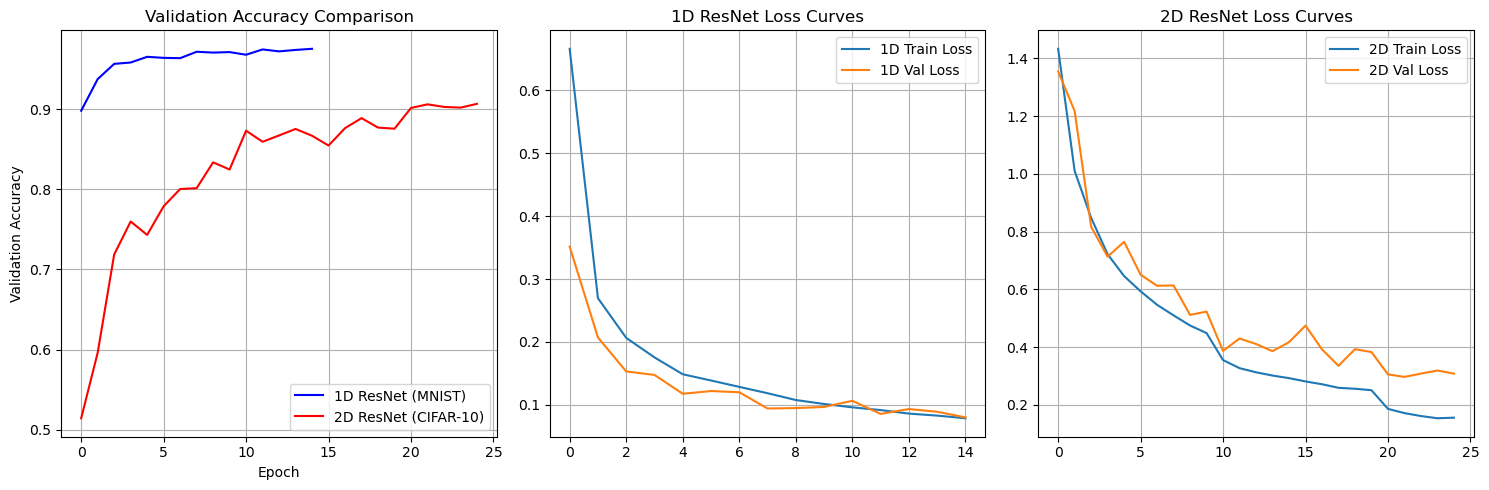

In [ ]:
# Plot both results side by side for comparison
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(hist_1d['val_acc'], label='1D ResNet (MNIST)', color='blue')
plt.plot(hist_2d['val_acc'], label='2D ResNet (CIFAR-10)', color='red')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(hist_1d['train_loss'], label='1D Train Loss')
plt.plot(hist_1d['val_loss'], label='1D Val Loss')
plt.title('1D ResNet Loss Curves')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(hist_2d['train_loss'], label='2D Train Loss')
plt.plot(hist_2d['val_loss'], label='2D Val Loss')
plt.title('2D ResNet Loss Curves')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Training 2D Residual CNN on CIFAR-10...
Model parameters: 4,906,122


Epoch 1/25 — train_loss: 1.4522, train_acc: 0.4653, val_acc: 0.5649, lr: 0.001000, time: 20.6s
Epoch 2/25 — train_loss: 1.0105, train_acc: 0.6385, val_acc: 0.6771, lr: 0.001000, time: 20.6s
Epoch 3/25 — train_loss: 0.8358, train_acc: 0.7071, val_acc: 0.6691, lr: 0.001000, time: 20.7s
Epoch 4/25 — train_loss: 0.7033, train_acc: 0.7562, val_acc: 0.7619, lr: 0.001000, time: 20.8s
Epoch 5/25 — train_loss: 0.6161, train_acc: 0.7855, val_acc: 0.7768, lr: 0.001000, time: 20.7s
Epoch 6/25 — train_loss: 0.5603, train_acc: 0.8058, val_acc: 0.7791, lr: 0.001000, time: 20.7s
Epoch 7/25 — train_loss: 0.5062, train_acc: 0.8266, val_acc: 0.8084, lr: 0.001000, time: 20.8s
Epoch 8/25 — train_loss: 0.4692, train_acc: 0.8414, val_acc: 0.8176, lr: 0.001000, time: 20.8s
Epoch 9/25 — train_loss: 0.4356, train_acc: 0.8510, val_acc: 0.8110, lr: 0.001000, time: 20.7s
Epoch 10/25 — train_loss: 0.4082, train_acc: 0.8593, val_acc: 0.8318, lr: 0.001000, time: 20.8s
Epoch 11/25 — train_loss: 0.3863, train_acc: 0.86

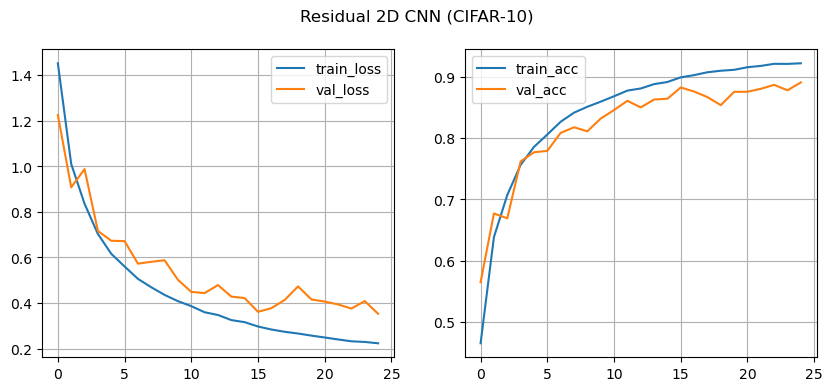

6. Model size: 1D ResNet: 441,226 vs 2D ResNet: 4,906,122 parameters


In [28]:
#experimenting


# Train the 2D Residual CNN
model_2d = Residual2D().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2d.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Learning rate scheduling

hist_2d = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

n_epochs = 25
print("Training 2D Residual CNN on CIFAR-10...")
print(f"Model parameters: {sum(p.numel() for p in model_2d.parameters()):,}")

for epoch in range(n_epochs):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model_2d, train_loader_2d, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model_2d, test_loader_2d, criterion, device)
    
    # Step the scheduler
    # scheduler.step()
    
    hist_2d['train_loss'].append(train_loss)
    hist_2d['val_loss'].append(val_loss)
    hist_2d['train_acc'].append(train_acc)
    hist_2d['val_acc'].append(val_acc)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{n_epochs} — train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, "
          f"val_acc: {val_acc:.4f}, lr: {current_lr:.6f}, time: {time.time()-t0:.1f}s")

print('\n2D Residual CNN test evaluation:')
val_loss, val_acc = evaluate(model_2d, test_loader_2d, criterion, device)
print(f'Final Test loss: {val_loss:.4f}, Final Test accuracy: {val_acc:.4f}')
plot_curves(hist_2d, title='Residual 2D CNN (CIFAR-10)')

# Print model sizes for comparison
params_1d = sum(p.numel() for p in model_1d.parameters())
params_2d = sum(p.numel() for p in model_2d.parameters())
print(f"6. Model size: 1D ResNet: {params_1d:,} vs 2D ResNet: {params_2d:,} parameters")

In [30]:
from torchsummary import summary

print("="*80)
print("MODEL ARCHITECTURE COMPARISON")
print("="*80)

print("\n1D RESIDUAL CNN (MNIST1D) SUMMARY:")
print("-" * 50)
summary(model_1d, input_size=(1, 784), device=str(device))

print("\n" + "="*80)
print("\n2D RESIDUAL CNN (CIFAR-10) SUMMARY:")
print("-" * 50)
summary(model_2d, input_size=(3, 32, 32), device=str(device))

# Detailed parameter comparison
print("\n" + "="*80)
print("DETAILED MODEL COMPARISON")
print("="*80)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

params_1d = count_parameters(model_1d)
params_2d = count_parameters(model_2d)
flops_ratio = params_2d / params_1d

print(f"1D ResNet Parameters: {params_1d:,}")
print(f"2D ResNet Parameters: {params_2d:,}")
print(f"Parameter Ratio (2D/1D): {flops_ratio:.2f}x")
print(f"Model Size Difference: {params_2d - params_1d:,} additional parameters")

# Memory usage comparison
def get_model_memory_mb(model, input_size):
    """Estimate model memory usage in MB"""
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / (1024**2)

mem_1d = get_model_memory_mb(model_1d, (1, 784))
mem_2d = get_model_memory_mb(model_2d, (3, 32, 32))

print(f"\nModel Memory Usage:")
print(f"1D ResNet: {mem_1d:.2f} MB")
print(f"2D ResNet: {mem_2d:.2f} MB")
print(f"Memory Ratio: {mem_2d/mem_1d:.2f}x")

MODEL ARCHITECTURE COMPARISON

1D RESIDUAL CNN (MNIST1D) SUMMARY:
--------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 392]             512
       BatchNorm1d-2              [-1, 64, 392]             128
         MaxPool1d-3              [-1, 64, 196]               0
            Conv1d-4              [-1, 64, 196]          12,352
       BatchNorm1d-5              [-1, 64, 196]             128
            Conv1d-6              [-1, 64, 196]          12,352
       BatchNorm1d-7              [-1, 64, 196]             128
   ResidualBlock1D-8              [-1, 64, 196]               0
            Conv1d-9              [-1, 128, 98]          24,704
      BatchNorm1d-10              [-1, 128, 98]             256
           Conv1d-11              [-1, 128, 98]          49,280
      BatchNorm1d-12              [-1, 128, 98]   